# Faster R-CNN experiments
This file contains experiments for my Faster R-CNN implementation. To access GPUs/TPUs, I ran this file in Google Colaboratory.

To pull from the GitHub repository in Colab:
```
%cd drive/MyDrive/Conservation\ Research/Code/counting-cranes
!git pull
```
----

In [2]:
#Will have to restart runtime after running this cell!
!pip install -r "/content/drive/MyDrive/Conservation Research/Code/counting-cranes/requirements.txt"

     |████████████████████████████████| 2.2MB 4.0MB/s 
     |████████████████████████████████| 17.4MB 183kB/s 
     |████████████████████████████████| 102kB 6.3MB/s 
     |████████████████████████████████| 15.3MB 266kB/s 
     |████████████████████████████████| 11.6MB 36.2MB/s 
     |████████████████████████████████| 808kB 34.5MB/s 
     |████████████████████████████████| 38.2MB 2.2MB/s 
     |████████████████████████████████| 112kB 49.5MB/s 
     |████████████████████████████████| 829kB 33.0MB/s 
     |████████████████████████████████| 10.6MB 28.7MB/s 
     |████████████████████████████████| 276kB 45.6MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 1.3MB 25.5MB/s 
     |████████████████████████████████| 296kB 33.1MB/s 
     |████████████████████████████████| 143kB 52.8MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=bb0c33c3910e63ddaa388dd07f8c22516a41bc2712c5e156a38a2cf6a806da4c
  Stored 

In [1]:
import json

config = json.load(open('/content/drive/MyDrive/Conservation Research/Code/counting-cranes/config.json', 'r'))
DATA_FP = config['data_filepath_colab']
CODE_FP = config['code_filepath_colab']
MODEL_SAVE_FP = config['model_saves_filepath_colab']
SEED = config['random_seed']
HYPERPARAMETERS = config['faster_rcnn_params']

In [2]:
import sys
import os
sys.path.append(CODE_FP) 
sys.path.append(os.path.join(CODE_FP, 'object_detection'))

from faster_rcnn_model import *
from bird_dataset import *

import torch
from torch.utils.data import DataLoader
from pytorch_lightning import seed_everything, Trainer
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

## Trying to get model training working

In [3]:
#Setting our random seed for all operaitons (PyTorch, numpy, python.random)
seed_everything(SEED);

Global seed set to 1693


In [3]:
#Creating a dataset and putting it into a dataloader
bird_dataset = BirdDataset(root_dir = DATA_FP, transforms = get_transforms(train = True), num_tiles = 10, max_neg_examples = 2) #no train/val/test split yet...
bird_dataloader = DataLoader(bird_dataset, batch_size = HYPERPARAMETERS['batch_size'], shuffle = True, collate_fn = collate_w_tiles) 

In [5]:
#Instantiating the model
model = get_faster_rcnn(num_classes = 2) #class for birds + class for background?
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate'])
pl_model #checking out the model summary

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNNLightning(
  (model): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [6]:
#Training the model, following the procedure outlined in PyTorch Lightning's documentation
checkpoint_dir = os.path.join(MODEL_SAVE_FP, 'faster_rcnn', 'trainer_checkpoints')
trainer = Trainer(gpus = 1, max_epochs = 6, default_root_dir = checkpoint_dir) #current max: 5 epochs
trainer.fit(pl_model, train_dataloader = bird_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  warnings.warn(*args, **kwargs)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | FasterRCNN | 41.3 M
-------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.197   Total estimated model params size (MB)


Global seed set to 1693


In [7]:
#Saving the model
save_name = 'initial_faster_rcnn.pth'
torch.save(model.state_dict(), os.path.join(MODEL_SAVE_FP, 'faster_rcnn', save_name))

## Qualitatively inspecting predictions from the trained model
To avoid memory errors, we have to save and load the model. Make sure to restart the runtime!

In [8]:
#Loading the model
save_name = 'initial_faster_rcnn.pth'
model = get_faster_rcnn(num_classes = 2) 
model.load_state_dict(torch.load(os.path.join(MODEL_SAVE_FP, 'faster_rcnn', save_name)))
pl_model = FasterRCNNLightning(model = model, lr = HYPERPARAMETERS['learning_rate'])

In [9]:
#Attempting a forward pass
images, targets = next(iter(bird_dataloader))
preds = pl_model(images)

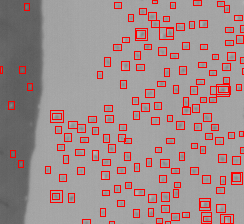

In [30]:
#Plotting an image and predicted bboxes
#  TODO: might need NMS on the prediction outputs (maybe change "box_nms_thresh" argument in "get_faster_rcnn")
#  TODO: maybe make a wrapper function to visualize predictions...
index = 9
img = np.moveaxis(images[index].numpy(), 0, -1) * 255
bboxes = preds[index]['boxes'].tolist()

pil_img = Image.fromarray(img.astype(np.uint8))
draw = ImageDraw.Draw(pil_img)
for b in bboxes:
    draw.rectangle(b, outline = 'red', width = 1)
pil_img

In [28]:
#Checking counts
print(f'We predicted {len(bboxes)} birds and there are actually {len(targets[index]["boxes"])} birds in this image')

We predicted 156 birds and there are actually 153 birds in this image
